# Análisis de tweets:

### Autores
- Maria Bellver
- Alejandro Sanz

## Objetivo del trabajo

En este trabajo se va a estudiar los datos obtenidos mediante la API de Twitter durante el periodo del 21 a 22 de Abril, concretamente capturando datos referentes al segundo episodio de la aclamada serie Juego de Tronos, empezando a las 12 de la noche de hora Española. Para ello con los datos obtenidos vamos a estudiar la cantidad de Tweets publicados por hora, un análisis de los usuarios con mayor número de retweets, un word cloud agrupando las palabras más comunes de los datos obtenidos y finalmenet realizaremos un análisis de polaridad para los personares principales de la serie.

## Datos del trabajo

A lo largo de las 24 horas de toma de datos se han obtenido los datos de _id, date,languaje, tweet y user. Considerando que filtrabamos para idioma Ingles, se obtuvieron un total de 1316402 registros, lo cual resulta un número más que suficiente para el analisis que se debe realizar.

## Importación librerías:

In [2]:
import pandas as pd
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests
import warnings
warnings.filterwarnings('ignore')

import sys, os


#from plotly import figure_factory as FF 

py.sign_in('sanzsana', 'E5zKeF4BqMTIneU1SK90') #claves plotly
accesstoken="pk.eyJ1Ijoic2FuenNhbmEiLCJhIjoiY2p1MHphZDFiMHBodjRlcDl6dWw3ZGZpbyJ9.U3ygIabawE-AxJ37lw_F4g" # clave mapbox

## Carga datos:

In [3]:
df = pd.read_csv('Captura.csv')
df.head()

,Unnamed: 0,_id,date,language,tweet,user
0,0,5cbce7eedd43f235f0b58032,2019-04-21 22:00:10,en,I’ve selected Jon Snow to sit on the Iron Thro...,Colonel_Calico
1,1,5cbce7efdd43f235f0b58034,2019-04-21 22:00:10,en,#GameofThrones is ending... it's time to disco...,TheSwithen
2,2,5cbce7efdd43f235f0b58036,2019-04-21 22:00:11,en,GameOfThrones : A new episode begins tonight a...,jgutierrez_phx
3,3,5cbce7efdd43f235f0b58038,2019-04-21 22:00:11,en,RT @Thrones_Memes: Tonight 🙌 #GameOfThrones ht...,foyboy30
4,4,5cbce7f0dd43f235f0b5803a,2019-04-21 22:00:11,en,The reason behind that surprising Cersei momen...,HuffPostUKEnt


## Tratamiento de los datos:

Unicamente nos interesará quedarnos con las horas, los usuarios y el contenido del propio Tweet, así como deberemos acondicionar los datos, en función de lo que deseemeos realizar. 

- Para el análisis de los Tweets por horas necesitaremos realizar una adecuación de los datos.

- Para el análisis de Retweets, vamos a estudiar los usuarios con mayor número de retweets. Primero debemos identificiar todos los tweets que contienen "RT @username", para tener filtrados únicamente los retweets. A partir de este subconjunto de datos se separa el nombre de usuario al cual se le ha realizado el RT y el propio texto escrito por dicho usuario obteniendo dos nuevas variables: user_orig y tweet_text.

- Para la creación del word Cloud, será necesario eliminar aquellos tweets que contengan hhtps:/..., ya que eso implica que en el propio tweet existe algún fichero adjunto (imagenes, video, etc.) que no deseamos.

- Para el análisis de polaridad eliminaremos tambien todos los Tweets que contentan algún fichero adjunto, como en el caso anterior, ya que se entiende que el texto hace referencia al fichero y, por tanto, se pierde el contexto del mismo.
    

### Procesado de datos 

In [4]:
# Para activar y desactivar los prints
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__


# Para adecuar los datos a las diferentes usos que se le darán.


def df_tr_gen(dataframe):
    a=dataframe.date.str.split(' ')
    hora=a.str[1]

    b=hora.str.split(':')
    b.str[0]

    hora=b.str[0]
    hora=hora.astype(int)+1


    dia=a.str[0].str.split('-').str[2].astype(int)


    dff=df[['language','user','tweet']].copy()
    dff['hora']=hora
    dff['dia']=dia

    dff.hora[dff.dia==21]=0
    dff.hora=dff.hora +1

    df1=dff.drop('dia', axis=1)
    df_tr_gen=df1[df1.hora!=24]
    return(df_tr_gen)

def df_RT(dataframe):
    
    df_RT=dataframe[dataframe.tweet.str.contains('RT @')==True].reset_index() #con esto nos quedamos unicamente con los RT y concretamente, con el campo que contiene el tweet.
    num_RT=len(dataframe[dataframe.tweet.str.contains('RT @')==True])
    porc_RT=len(dataframe[dataframe.tweet.str.contains('RT @')==True])/len(df)
    print('Tenemos un total de',num_RT, 'RT, que será un',porc_RT,'% del conjunto total de datos.')
    df_RT_util=df_RT[['hora','tweet']] # seleccionamos un  subset
    df_RT_util['Count']=df_RT_util.groupby(['tweet'],sort=True).transform('count')
    df_RT_split=list(df_RT_util.tweet.str.split('@',1)) # Para separar los usuarios del tweet original del texto.

    texto=[] #Para obtener bien el nombre de usuario
    for i in range(len(df_RT_split)):
        fila1=df_RT_split[i][1]
        texto.append(fila1.split(':',1))
    df_text_userorig=pd.DataFrame(texto)
    df_RT_util['user_orig']=df_text_userorig.loc[:,0]
    df_RT_util['tweet_text']=df_text_userorig.loc[:,1]
    df_RT_util.hora=24-df_RT_util.hora # modificamos las horas para saber cuantas horas han estado online.
    
    return(df_RT_util)


def df_RT2(dataframe):
    
    df_RT=dataframe[dataframe.tweet.str.contains('RT @')==True].reset_index() #con esto nos quedamos unicamente con los RT y concretamente, con el campo que contiene el tweet.
    
    df_RT_util=df_RT[['user','tweet']] # seleccionamos un  subset
    df_RT_split=list(df_RT_util.tweet.str.split('@',1)) # Para separar los usuarios del tweet original del texto.

    texto=[] #Para obtener bien el nombre de usuario
    for i in range(len(df_RT_split)):
        fila1=df_RT_split[i][1]
        texto.append(fila1.split(':',1))
    df_text_userorig=pd.DataFrame(texto)
    df_RT_util['user_orig']=df_text_userorig.loc[:,0]
    df_RT_util['tweet_text']=df_text_userorig.loc[:,1]

    
    return(df_RT_util)

#######################################################################################################################

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return(score)
def polaridad(df):
    score=[]
    for j in np.arange(len(np.array(df.tweet))):
        score.append(sentiment_analyzer_scores(np.array(df.tweet)[j]))
        
    polaridad=[]
    for i in np.arange(len(score)):
        if(score[i]['compound']==0):
            polaridad.append('neutro')
        elif(score[i]['compound']>0):
            polaridad.append('positivo')
        elif(score[i]['compound']<0):
            polaridad.append('negativo')
    df['polaridad']=polaridad
    
    pos=polaridad.count('positivo')
    neg=polaridad.count('neutro')
    neu=polaridad.count('negativo')
    return(pos,neg,neu)

def personajes(pers):

    personajes=['Daenerys','Cersei','Jaime','Jon','Sansa','Arya','Tyrion','Bran','Night king']
    casa=['Targaryen','Lannister','Lannister','Stark', 'Stark', 'Stark', 'Lannister','Stark','White walker']


    pos=[]
    neg=[]
    neu=[]
    pos_per=[]
    neg_per=[]
    neu_per=[]
    for i in np.arange(len(pers)):
        perso=r'(\b{}\b)'.format('|'.join(pers[i]))
        perso=df2[df2['tweet'].str.contains(perso)]
        posi,nega,neut=polaridad(perso)
        pos_pers=(posi*100)/(posi+nega+neut)
        neg_pers=(nega*100)/(posi+nega+neut)
        neu_pers=(neut*100)/(posi+nega+neut)
        pos_per.append(pos_pers)
        neg_per.append(neg_pers)
        neu_per.append(neu_pers)
        pos.append(posi)
        neg.append(nega)
        neu.append(neut)
        

    dic={'Personaje':personajes, 'Casa': casa, 'Positivos': pos, 'Pos_percent':pos_per, 'Negativos': neg, 
         'Neg_percent':neg_per,'Neutros': neu,'Neu_percent':neu_per}
    personaje=pd.DataFrame(dic)
    return(personaje)

# Análisis general:

## Scatterplot animado:

In [5]:
### Para llamar al dataframe limpio y agrupar los tweets por horas

df_tr_gen=df_tr_gen(df)
tweet_hora=df_tr_gen.groupby('hora').count().tweet #para saber cuantos tweets tengo por hora

#Para crear las trazas y el plot animado


x = list(np.arange(1,24))
y = list(tweet_hora)
trace1 = {
  "type": "scatter"
}

trace2=go.Scatter(
    x = x,
    y = y,
    mode = 'lines+markers',
    name = 'lines+markers')

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Hora:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}
data = Data([trace1,trace2])
updatemenus = dict(

    # GENERAL
    direction="left",
    pad = dict(
        r=10,
        t=87),
    type = "buttons",
    showactive = False,
    x = 0.1,
    y = 0,
    xanchor = "right",
    yanchor = "top",

    # BUTTONS
    buttons=[
        dict(
            method = "animate",
            label = "Play",

            # PLAY
            args = [
                None,
                dict(
                    frame = dict(duration = 500, redraw = False), # False quicker but disables animations
                    fromcurrent = True,
                    transition = dict(duration = 300, easing = "quadratic-in-out"), # easing = "cubic-in-out"
                    ),
                ],
            ),
        dict(
            method = "animate",
            label = "Pause",

            # PAUSE
            args = [
                [None], # Note the list
                dict(
                    frame = dict(duration = 0, redraw = False), # Idem
                    mode = "immediate",
                    transition = dict(duration = 0),
                    ),
                ],
            )
        ],

)
layout = dict(

    title = "Número total de Tweets en 24h",

    # GENERAL LAYOUT
    height = 350,
    font = dict(
        color = "white",
    ),
    margin = dict(
        r=60,
        t=40,
        b=40,
        l=60
    ),
    showlegend = False,
    hovermode = "closest",

    # ANIMATIONS
    sliders = [sliders_dict],
    updatemenus = [updatemenus],

    # COLOR THEME
    plot_bgcolor = "black",
    paper_bgcolor = "black",

  
    xaxis = dict(
        range = [x[0], x[22]],
        domain = [0, 1],
        anchor = "y4",
        title = "Hora",
    ),
    yaxis=dict(
    domain=[0,1],
    gridcolor="#444",
    title="Conteo Tweets",
    zerolinecolor="#444",
    )
)



frame=[]
for i in (np.arange(23)):
    
    frame1 = {
        "data": [
            {
              "x": [x[i]], 
              "y": [y[i]], 
              "marker": {
                "color": "rgb(0,107,204)", 
                "symbol": "circle",
                "size": 10,
                },
              "mode": "lines+markers", 
              "type": "scatter",
              "name":str(i)
            }
        ],
      'name': str(i),
      "traces": [0,1]
    }
    slider_step = {'args': [
        [i],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': int(i+1),
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)
    frame.append(frame1)

fig = go.Figure(data=data, layout=layout, frames=frame)

py.icreate_animations(fig) 

Para analizar la gráfica anterior es necesario tener el conocimiento previo de que el segundo episodio de GOT se emitía a las 3 de la madrugada de hora Española, es decir a las 9 de la noche de la zona Este de EEUU.

Por tanto, podemos observar un máximo local a 3 de la madrugada ( hora Española) , debido al estreno del segundo episodio, así como a las 5 de la mañana que coincide con las 8 de la tarde de la zona Oeste de EEUU, cuando la gente sale de trabajar y llega a casa. A lo largo del resto del dia, se pude observar otro crecimiento en las horas de tarde correspondientes a Europa.

## Análisis de retweets:

In [6]:
df_RT_plot=df_RT(df_tr_gen) #llamamos a la funcion que nos genera el dataframe de RT
df_RT_plot=df_RT_plot.drop_duplicates(subset='tweet', keep='first', inplace=False)
df_RT_plot=df_RT_plot.sort_values(by='Count',ascending=False) #ordenamos los datos
df_RT_plot=df_RT_plot.head(10) #Selecciono los 10 primeros.


x1=list(df_RT_plot.user_orig[0:8])
x1.append(df_RT_plot.user_orig.iloc[9])
x2=[df_RT_plot.user_orig.iloc[8]]

y1=list(df_RT_plot.Count[0:8])
y1.append(df_RT_plot.Count.iloc[9])
y2=[df_RT_plot.Count.iloc[8]]

text1=list(df_RT_plot.tweet[0:8])
text1.append(df_RT_plot.tweet.iloc[9])
text2=[df_RT_plot.tweet.iloc[8]]


RT1 = go.Bar(
    x=x1,
    y=y1,
    text=text1
)
RT2 = go.Bar(
    x=x2,
    y=y2,
    text=list(text2)
)

data = [RT1, RT2]
layout = go.Layout(
    title='Top 10 de RT',
    barmode='group',
    showlegend=False,
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

Tenemos un total de 963667 RT, que será un 0.7320461378818932 % del conjunto total de datos.


Vemos que los 2 usuarios con mayor número de RT son aquellos que han publicado memes relacionados con los sucesos del episodio (el texto va acompañado de una url). El tercer usuario con mayor número de RT ha publicado 2 tweets a lo largo de las 24 horas, que han tenido mucha relevancia ya que muestra el *hype* existente por el tercer episodio de la serie donde se desarollará una de las batallas más importantes de toda la serie, así como otro donde muestra el tiempo de duración estimado de cada uno de los episodios restantes de la serie.

Como comentario final cabe destacar que práticamente todos los RT obtenidos se deben a memes que ha realizado la comunidad de seguidores de la serie.

## Word cloud

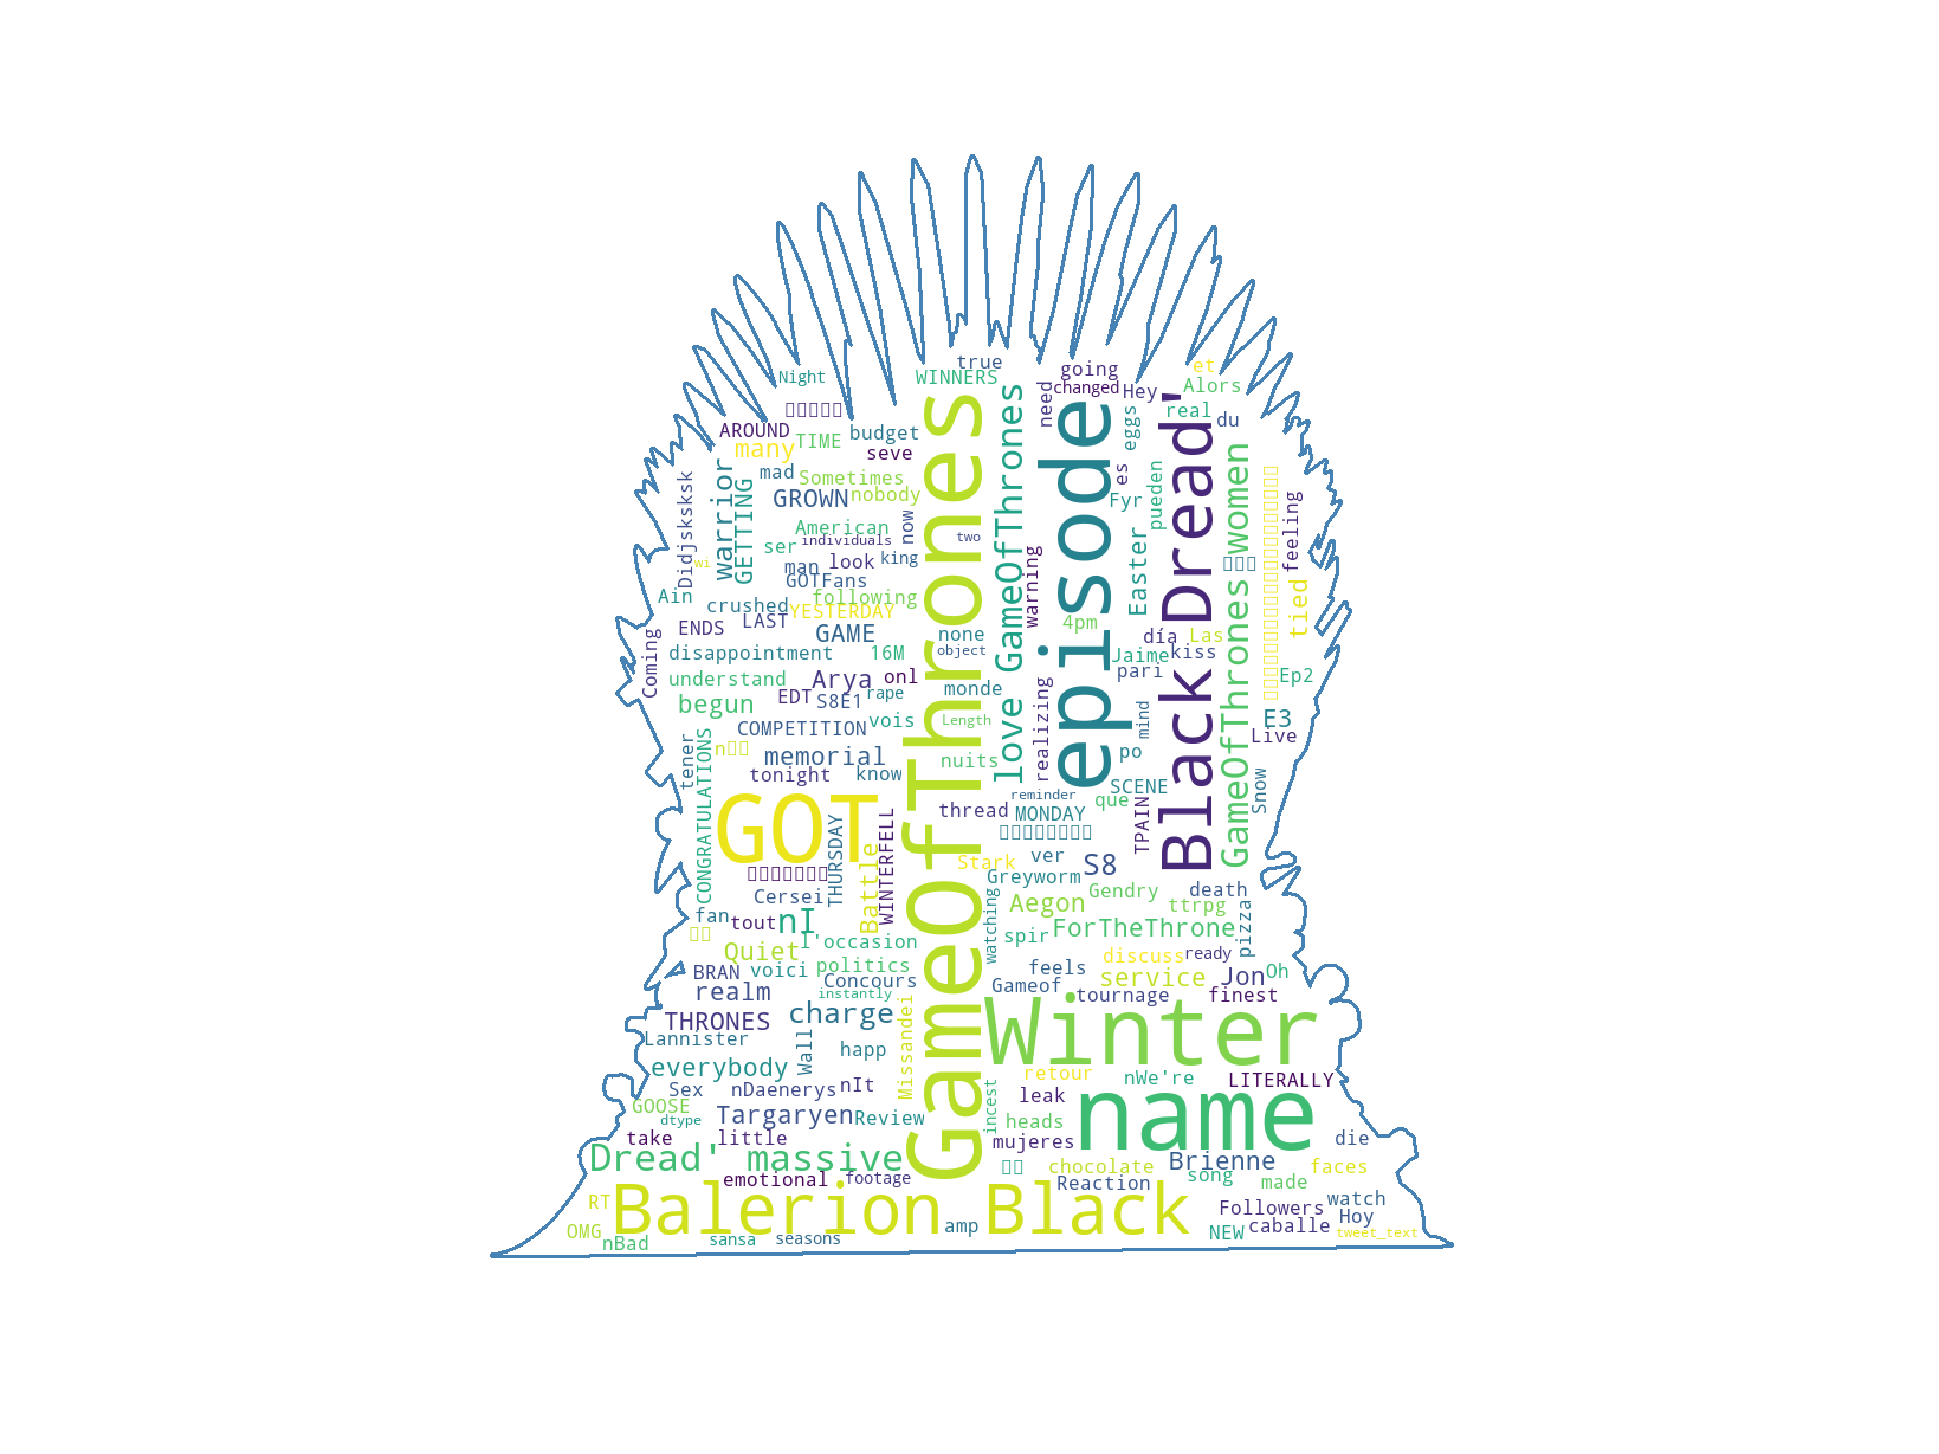

In [7]:
df_WC=df[df.tweet.str.contains('http')==False]
df_WC=df_RT2(df_WC)
stop_words = ["tha", "de","nFollow",'le','nWe','pedir','Je','nCinematography'] + list(STOPWORDS)
blockPrint()
words=str(df_WC.tweet_text)

mask = np.array(Image.open("th2.png"))

# This function takes in your text and your mask and generates a wordcloud. 
def generate_wordcloud(words, mask):
    word_cloud = WordCloud(width = 512, height = 512, background_color='white', stopwords=stop_words, mask=mask,contour_width=3, contour_color='steelblue').generate(words)
    plt.figure(figsize=(40,20),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    
#Run the following to generate your wordcloud
generate_wordcloud(words, mask)
enablePrint()

Con respecto al Word Cloud, podemos observar que se meciona mucho GameOfThrones y GOT, en refercia a los hashtags, así como S8 en referecia a la octava temporada, algunos nombres de personajes, entre otros. Destaca la combinación "Black dread" que hace referencia al final del capítulo así como "name" que resulta importante en cierta trama del mismo.

# Análisis por personaje:

Como se ha explicado anteriormente en esta sección se parte del subconjunto de tweets que no contienen url's en el texto. Con la función definida `personajes()` obtenemos un data frame con los personajes de la lista `pers`y la casa a la que pertenecen, así, como el número de tweets de cada uno clasificados en cada categoría de polaridad (Positivo, negativo, neutro) y su correspondiente porcentaje. 

In [8]:
df=df[df.tweet.str.contains('http')==False]
df2=df.drop(['Unnamed: 0', '_id','user'],axis=1)
dany=['Daenerys','daenerys','Danny','danny','Khaleesi','khaleesi']
cersei=['Cersei','cersei']
jaime=['Jaime', 'jaime']
jon=['Jon','jon','Snow','snow','Aegon','aegon']
sansa=['Sansa','sansa']
arya=['Arya','arya']
tyrion=['Tyrion','tyrion']
bran=['Bran','bran','Three-Eyed Raven']
king=['Nigth king','White walker','white']

pers=[dany,cersei,jaime,jon,sansa,arya,tyrion,bran,king]
personaje=personajes(pers)

In [9]:
personaje

,Personaje,Casa,Positivos,Pos_percent,Negativos,Neg_percent,Neutros,Neu_percent
0,Daenerys,Targaryen,4387,19.375497,14434,63.748785,3821,16.875718
1,Cersei,Lannister,597,23.728140,658,26.152623,1261,50.119237
2,Jaime,Lannister,7549,34.636384,10910,50.057353,3336,15.306263
3,Jon,Stark,3591,12.045889,18406,61.742310,7814,26.211801
4,Sansa,Stark,6029,20.833477,17554,60.658627,5356,18.507896
5,Arya,Stark,9619,18.259995,20901,39.676905,22158,42.063100
6,Tyrion,Lannister,1454,40.671329,1291,36.111888,830,23.216783
7,Bran,Stark,6921,41.642599,5855,35.228640,3844,23.128761
8,Night king,White walker,311,14.987952,355,17.108434,1409,67.903614


Cabe destacar que, para la función `polaridad()` donde se clasifican los textos en las tres categorias, se ha decidido utilizar la librería VADER de análisis de sentimiento, basada en lexicon, por su rapidez y por el análisis que hace de los emoticonos y el argot de redes sociales.

## Polaridad:

In [10]:
from collections import OrderedDict
from math import log, sqrt

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

pol_color = OrderedDict([
    ("Positivos",   "#1E8449"),
    ("Neutros",     "#1F618D"),
    ("Negativos", "#922B21")
    
])

casa_color = OrderedDict([
    ("Targaryen", "#D98880"),
    ("Lannister", "#F8C471"),
    ("Stark", "#7FB3D5"),
    ("White walker", "#D0D3D4")
])


width = 800
height = 800
inner_radius = 90
outer_radius = 300 - 10

minr = sqrt(10)
maxr = sqrt(100)
a = (outer_radius - inner_radius) / (maxr-minr)
b = outer_radius - a * maxr

def rad(mic):
    return a * np.sqrt(mic) + b

big_angle = 2.0 * np.pi / (len(personaje) + 1)
small_angle = big_angle / 7

p = figure(plot_width=width, plot_height=height, title="Porcentajes de polaridad:",
    x_axis_type=None, y_axis_type=None,
    x_range=(-350, 350), y_range=(-350, 350),
    min_border=0, outline_line_color="black",
    background_fill_color="#F6DDCC")
p.title.text_font_size = '15pt'

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

# annular wedges
angles = np.pi/2 - big_angle/2 - personaje.index.to_series()*big_angle
colors = [casa_color[casa] for casa in personaje.Casa]
p.annular_wedge(
    0, 40, outer_radius, inner_radius, -big_angle+angles, angles, color=colors,
)

# small wedges
p.annular_wedge(0, 40, inner_radius, rad(personaje.Pos_percent),
                -big_angle+angles+5*small_angle, -big_angle+angles+6*small_angle,
                color=pol_color['Positivos'])
p.annular_wedge(0, 40, inner_radius, rad(personaje.Neu_percent),
                -big_angle+angles+1*small_angle, -big_angle+angles+2*small_angle,
                color=pol_color['Neutros'])
p.annular_wedge(0, 40, inner_radius, rad(personaje.Neg_percent),
                -big_angle+angles+3*small_angle, -big_angle+angles+4*small_angle,
                color=pol_color['Negativos'])


# circular axes and lables
labels = np.array([10,20,30,40,50,60,70,80,90,100])
labels1 = np.array([10,20,30,40.5,51,61,71,81.5,92,102])
radii = a*np.sqrt(labels) + b
radii1 = a*np.sqrt(labels1) + b

p.circle(0, 40, radius=radii, fill_color=None, line_color="white")
p.text(0, radii1[:]+40, [str(r) for r in labels[:]],
       text_font_size="11pt", text_align="center", text_baseline="middle")

# radial axes
p.annular_wedge(0, 40, inner_radius-10, outer_radius+10,
                -big_angle+angles, -big_angle+angles, color="black")

# House labels
xr = 3*radii[0]*np.cos(np.array(-big_angle/2 + angles))
yr = 3*radii[0]*np.sin(np.array(-big_angle/2 + angles))
label_angle=np.array(-big_angle/2+angles)
label_angle[label_angle < -np.pi/2] += np.pi # easier to read labels on the left side
p.text(xr, yr+40, personaje.Personaje, angle=label_angle,
       text_font_size="11pt", text_align="center", text_baseline="middle")

# OK, these hand drawn legends are pretty clunky, will be improved in future release
p.circle([-40, -40,-40,-40], [-270, -290, -310,-330], color=list(casa_color.values()), radius=5)
p.text([-30, -30,-30,-30], [-270, -290,-310,-330], text=[cs for cs in casa_color.keys()],
       text_font_size="9pt", text_align="left", text_baseline="hanging")

p.rect([-40, -40, -40], [68, 50, 32], width=30, height=13,
       color=list(pol_color.values()))
p.text([-15, -15, -15], [68, 50, 32], text=list(pol_color),
       text_font_size="11pt", text_align="left", text_baseline="middle")

output_notebook()


Loading BokehJS ...

In [11]:
show(p)

Podemos ver que destacan Daenerys, Jaime, Jon y Sansa con alrededor del 60% de los tweets negativos mientras que Bran y Tyrion obtienen poco más del 50% de los tweets positivos. Arya, en cambio, obtiene sobre un 30% tanto de comentarios negativos como de neutros. También, observamos que Cersei tiene alrededor del 25% tanto de tweets positivos como negativos y el otro 50% de neutros. Por último, destaca el Night king por tener casi el 70 % de los tweets neutros.
